# Homework 4. Multiobjective Optimization

### Evolutionary Computation

Dr. Jesús Guillermo Falcón Cardona

* Denisse Chacón Ramírez [A01378965]
* Emilio Rios Ochoa [A01378965]

## Introduction

Optimization problems are widely present in real life, spanning across various industries and knowledge areas. These are alass of optimization problems that involve the simultaneous optimization of two or more objectives [3]. A key characteristic of these problems is that their objective are in conflict, implying that there is a trade-off between the improvement in some and the worsening of others. This is where Multi-Objective optimization (MO) and Multi-Objective Evolutionary Algorithms (MOEA) come into play. One of the most popular MOEAs is the Non-dominated Sorting Genetic Algorithm II (NSGA-II) which although may not be the best, it is still quite relevant and it essentially works by determining the number of dominating solutions for each individual in the population (Pareto dominance) and breaking ties with the Crowding Distance algorithm [4]. Additionally, regarding the problems, there exists a set of problems named after their authors Deb, Thiele, Laumanns and Zitzler that serve as reference to test MOEAs due to their diverse shapes, continuity and convexity [5].

In this study, we utilize the traditional NSGA-II algorithm, as well as a modified version of it using the crossover and mutation operators of Differential Evolution (DE), hence, naming this hybrid version NSDE-II. We test them against four of the well-known DTLZ problems and their inverted versions, to assess if using a this hybrid version has an advantage over the traditional implementation, for which we use Quality Indicators (QI) such as the R2 and Riesz s-Energy measures and Wilcoxon statistical tests to compare these results.

## Implementation

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from scipy.stats import ranksums
from scipy.spatial.distance import pdist, squareform
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.core.population import Population
from pymoo.problems.many import DTLZ1, DTLZ2, DTLZ5, DTLZ7
from pymoo.core.problem import Problem
from pymoo.problems.functional import FunctionalProblem
from itertools import combinations_with_replacement

<hr />

### Problem Definition

To test our implementations, we use the DTLZ problems, specifically, DTLZ1, DTLZ2, DTLZ5 and DTLZ7, as well as their inverted versions. <br />
In order to be able to graph, we set the number of objectives ($m$) to 3. Whilst the number of decision variables ($n$) is defined by using the formula $n = m + k - 1$

* For DTLZ1,            $k = 5$
* For DTLZ2 - DTLZ6,    $k = 10$
* For DTLZ7,            $k = 20$

In [23]:
m_Objectives = 3
n_Variables = [m_Objectives + k - 1 for k in [5, 10, 10, 20]]

for i, dtlz in enumerate([1, 2, 5, 7]):
    print(f"# of Variables for DTLZ{dtlz}: {n_Variables[i]}")

PROBLEMS = {
    "DTLZ" : { 
        f"DTLZ{i}" : get_problem(f"DTLZ{i}", n_var=var, n_obj=m_Objectives) for i, var in zip([1, 2, 5, 7], n_Variables) 
    }
}

# of Variables for DTLZ1: 7
# of Variables for DTLZ2: 12
# of Variables for DTLZ5: 12
# of Variables for DTLZ7: 22


Next, we define the inverted versions of the problems. <br />
To achieve this, we have to invert every single objective of each problem as follows:

$f_i(x) \leftarrow 0.5(1 + g(x)) - f_i(x)$

However, we can leverage Pymoo's existing implementations of the DTLZ problems and just apply the aforementioned transformation instead of computing everything from scratch.

In [24]:
class IDTLZ1(DTLZ1):
    def __init__(self, n_var, n_obj):
        super().__init__(n_var, n_obj)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g1(X_M)

        super()._evaluate(x, out, *args, **kwargs)
        out["F"] = 0.5 * (1 + g[:, None]) - out["F"]

In [25]:

class IDTLZ2(DTLZ2):
    def __init__(self, n_var, n_obj):
        super().__init__(n_var, n_obj)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g1(X_M)

        super()._evaluate(x, out, *args, **kwargs)
        out["F"] = 0.5 * (1 + g[:, None]) - out["F"]

In [26]:
class IDTLZ5(DTLZ5):
    def __init__(self, n_var, n_obj):
        super().__init__(n_var, n_obj)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g1(X_M)

        super()._evaluate(x, out, *args, **kwargs)
        out["F"] = 0.5 * (1 + g[:, None]) - out["F"]

In [27]:
class IDTLZ7(DTLZ7):
    def __init__(self, n_var, n_obj):
        super().__init__(n_var, n_obj)

    def _evaluate(self, x, out, *args, **kwargs):
        X_, X_M = x[:, :self.n_obj - 1], x[:, self.n_obj - 1:]
        g = self.g1(X_M)

        super()._evaluate(x, out, *args, **kwargs)
        out["F"] = 0.5 * (1 + g[:, None]) - out["F"]

In [28]:
PROBLEMS["IDTLZ"] = {
    "IDTLZ1" : IDTLZ1(n_var=n_Variables[0], n_obj=m_Objectives),  
    "IDTLZ2" : IDTLZ2(n_var=n_Variables[1], n_obj=m_Objectives),  
    "IDTLZ5" : IDTLZ5(n_var=n_Variables[2], n_obj=m_Objectives),  
    "IDTLZ7" : IDTLZ7(n_var=n_Variables[3], n_obj=m_Objectives)  
}

We display the actual Pareto fronts of each respective function, as a way to see the goal of what we're trying to get. Ishibuchi, _et. al_ [2] mentions that the optimal solutions of non-inverted DTLZ problems (using DTLZ2 as reference) are obtained when the distance variables are 0.5, whereas for the inverted verions, are obtained when they are either 0 or 1. Therefore, our intuition to obtain the real pareto front of the inverted versions was to perform $0.5 - P$, where $P$ is the set of points in the non-inverted DTLZ's Pareto front.

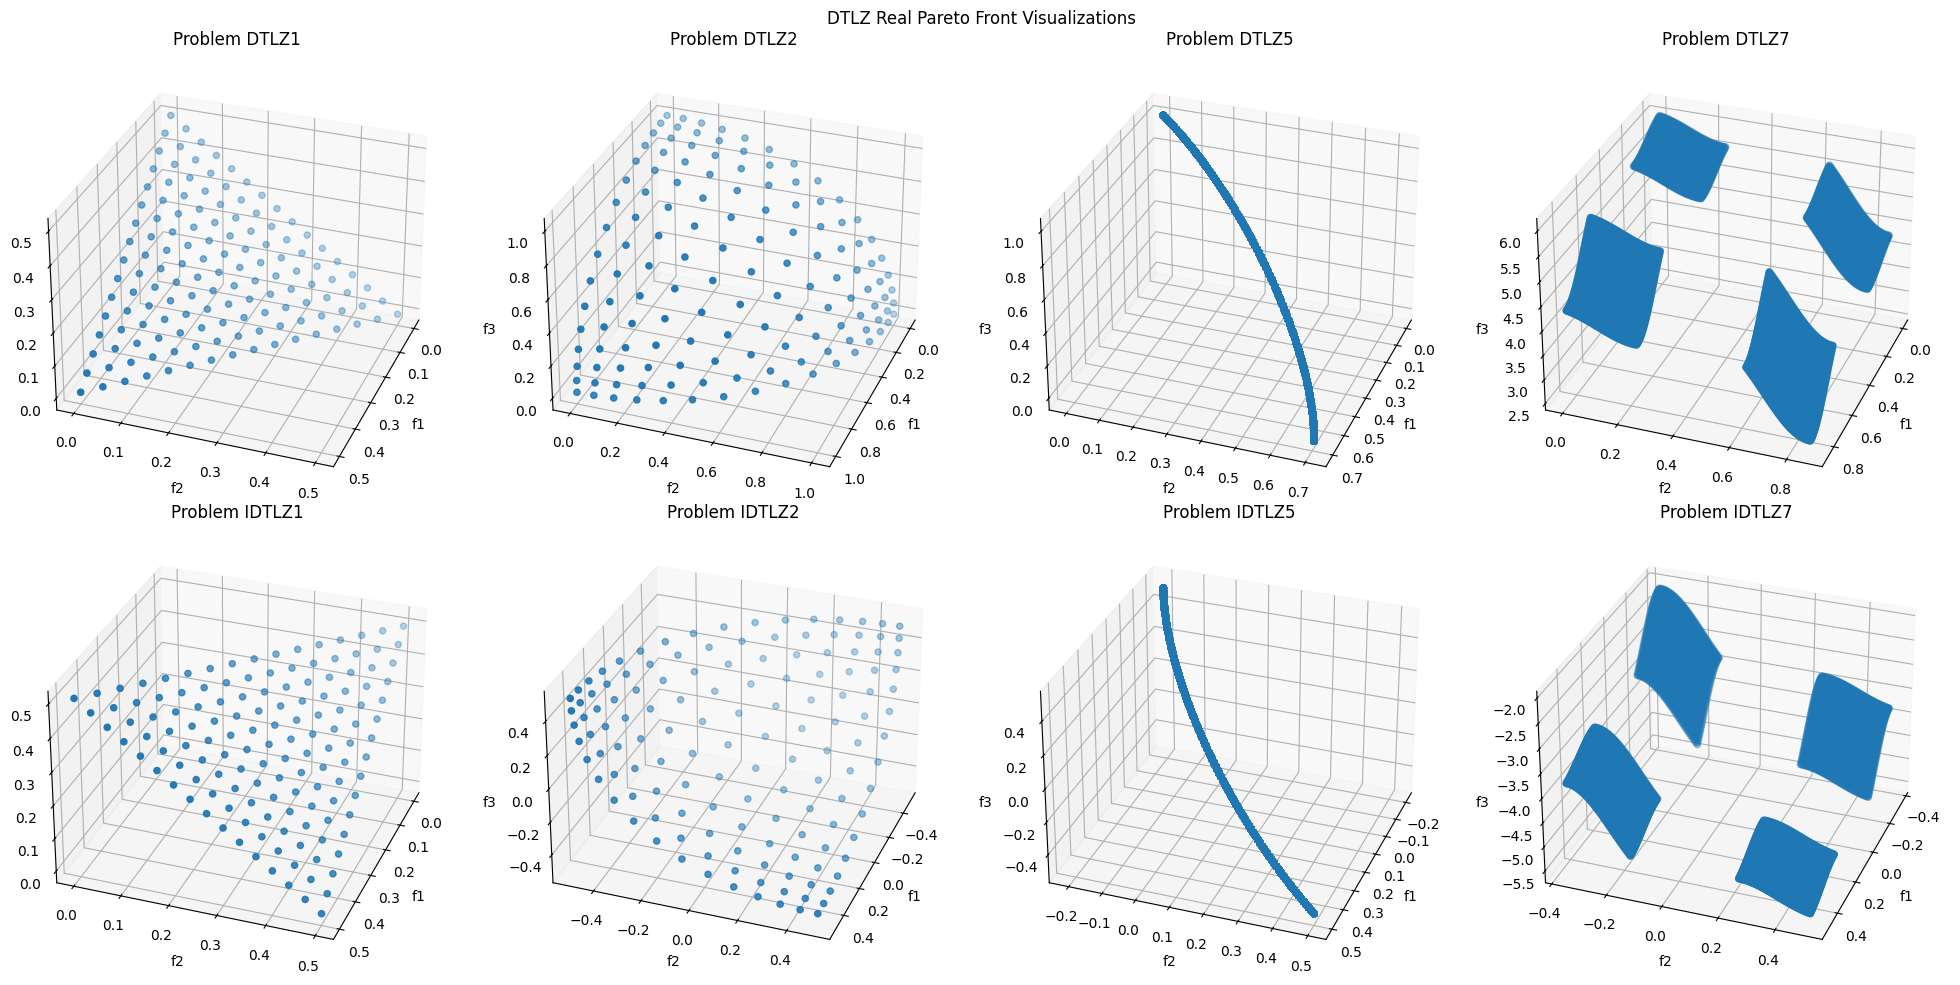

In [29]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), subplot_kw={"projection" : "3d"})

scatterPlots = []
for i, category in enumerate(PROBLEMS):
    for j, problem in enumerate(PROBLEMS[category]):
        paretoFront = PROBLEMS[category][problem].pareto_front() if category == "DTLZ" else 0.5 - PROBLEMS[category][problem].pareto_front()

        ax[i, j].scatter(paretoFront[:, 0], paretoFront[:, 1], paretoFront[:, 2])
        ax[i, j].set_title(f"Problem {problem}")
        ax[i, j].set_xlabel("f1")
        ax[i, j].set_ylabel("f2")
        ax[i, j].set_zlabel("f3")
        ax[i, j].view_init(elev=30, azim=20)

fig.suptitle("DTLZ Real Pareto Front Visualizations")
plt.tight_layout()
plt.show()

<hr />

### Algorithms' Implementation

#### NSGA-II

Traditional approach using Pymoo's existent implementation of the Nondominated Sorting Genetic Algorithm II (NSGA-II) using Simulated Binary Crossover (SBX) as crossover operator and Polynomial Mutation (PM) as mutation operator.

In [30]:
NSGA = NSGA2(
    pop_size                =   100,
    crossover               =   SimulatedBinaryCrossover(),
    mutation                =   PolynomialMutation(),
    eliminate_duplicates    =   True
)

#### NSDE-II

Our custom variation of the NSGA-II using Differential Evolution (DE) operators to replace the SBX crossover and PM mutation operators.

* **Mutation:** Only 1 weighted difference
* **Crossover:** Binomial crossover

In [45]:
class NSDE2(NSGA2):
    def __init__(self, pop_size, eliminate_duplicates, F=0.1, P_r=0.9):
        super().__init__(pop_size=pop_size, eliminate_duplicates=eliminate_duplicates)
        self.F = F  
        self.P_r = P_r
    
    def _infill(self):
        # Decode the population into arrays
        population = self.pop.get("X")
        popSize = len(self.pop)
        indSize = population.shape[1]
    
        # Generate offspring population
        newPopulation = np.empty((popSize, indSize))
        for i in range(popSize):
            # Mutation Operation
            indices = [ind for ind in range(popSize) if ind != i]
            a_idx, b_idx, c_idx = np.random.choice(indices, 3, replace=False)
            a, b, c = population[a_idx], population[b_idx], population[c_idx]
            trial = a + self.F * (b - c)

            # Binomial Crossover
            target = np.copy(population[i])
            chance = np.random.randint(indSize)
            for j in range(indSize):
                if np.random.rand() <= self.P_r or j == chance:
                    target[j] = trial[j]
            target = np.clip(target, self.problem.xl, self.problem.xu)
            newPopulation[i] = target

        # Evaluate the offspring
        offspring = Population.new("X", newPopulation)
        self.evaluator.eval(self.problem, offspring)

        # Combine parents and offspring
        combined = Population.merge(self.pop, offspring)

        # Use the NSGA-II's regular selection of the best μ elements
        self.pop = self.survival.do(self.problem, combined, popSize)

        return offspring

In [33]:
NSDE = NSDE2(
    pop_size                =   100,
    eliminate_duplicates    =   True
)

<hr />

### Execution

Perform 30 runs per problem and solve them with both NSGA-II and NSDE-II storing their results for future analysis.

In [ ]:
NSGAresults = { category: { problem : [] for problem in PROBLEMS[category] }  for category in PROBLEMS }
NSDEresults = { category: { problem : [] for problem in PROBLEMS[category] }  for category in PROBLEMS }

for i, category in enumerate(PROBLEMS):
    for j, problem in enumerate(PROBLEMS[category]):
        print(f"Solving problem {problem}...\n")
        for _ in range(30):
            NSGAresults[category][problem].append(
                minimize(
                    PROBLEMS[category][problem],
                    NSGA,
                    ("n_gen", 500),
                    verbose = False
                )
            )
            NSDEresults[category][problem].append(
                minimize(
                    PROBLEMS[category][problem],
                    NSDE,
                    ("n_gen", 500),
                    verbose = False
                )
            )

Solving problem DTLZ1...

Solving problem DTLZ2...

Solving problem DTLZ5...

Solving problem DTLZ7...

Solving problem IDTLZ1...

Solving problem IDTLZ2...

Solving problem IDTLZ5...

Solving problem IDTLZ7...



<hr />

### Perfromance Assessment

To measure the diversity obtained with our solutions, we utilize the Riesz s-Energy indicator [1], described as follows:

$E_s = \sum_{i=1}^N \sum_{j=1, j \ne 1}^N k_s(\vec{a_i}, \vec{a_j})$

$k_s(\vec{a_i}, \vec{a_j}) = \frac{1}{||\vec{a_i} - \vec{a_j}||^s}$

However, to avoid overflow of large values, we apply the transformation:

$E_s^{\ln} = \ln (1 + E_s) $

For this study, we set $s = m - 1$, and since in all our cases, we have 3 objectives, $m=3 \therefore s = 2$.

In [35]:
def riesz_kernel(x, y, s):
    if np.all(x == y):
        return 0
    return 1/np.power(np.linalg.norm(x - y), s)

def Riesz_sEnergyIndicator(PFA):
    s_value = 2
    # Get the number of dimensions to set s parameter.
    m = PFA.shape[1]
    # It only calculates n(n-1)/2 elements on the (upper or lower) triangular matrix.
    pairwise_kernels = pdist(PFA, lambda u, v: riesz_kernel(u, v, s_value))
    # Generate the full squared matrix.
    K = squareform(pairwise_kernels)

    U = np.sum(K)

    return np.log(1 + U)

Another indicator to assess the performance is the discrete R2 indicator. 

$R2(A, W, z*) = \frac{1}{|W|}\sum_{\vec{w}\in W} \min_{\vec{a} \in A} \{ u_{\vec{w}}(\vec{a}) \}$

Where $A$ is the Pareto front approximation obtained by the respective MOEA. Where $W$ is a set of weights with the same length as the number of objectives. These weights are set randomly so that their sum equals 1. Finally, $z*$ is the real Pareto front / ideal set of points. For $u_{\vec{w}}(\vec{a})$ we use the Achievement Scalarizing Function (ASF) [6] defined as:

$u_{\vec{w}}(\vec{a})= \max_{i=1,2,...,m}\{ \frac{\vec{a}-\vec{z}^*}{w_i}\} $

In [36]:
def normalize(front):
    frontMin = np.min(front, axis=0)
    frontMax = np.max(front, axis=0)
    return (front - frontMin) / (frontMax - frontMin + 1e-6)

In [37]:
def generateWeights(popSize, indSize):
    randomPoints = np.random.uniform(0, 1, size=(popSize, indSize - 1))
    sortedPoints = np.sort(np.hstack((np.zeros((popSize, 1)), randomPoints, np.ones((popSize, 1)))), axis=1)
    return np.diff(sortedPoints, axis=1)

In [38]:
def R2Indicator(front, referenceFront):
    normalizedFront = normalize(front)
    normalizedReference = normalize(referenceFront)
    
    # Get the utopian point
    utopianPoint = np.array([np.min(normalizedReference[:, 0]), np.min(normalizedReference[:, 1]), np.min(normalizedReference[:, 2])])

    # Generate arbitrary weights
    weights = generateWeights(len(front), normalizedFront.shape[1])

    r2_values = []
    for i in range(len(normalizedFront)):
        min_max_values = []
        # Iterate over each objective
        for j in range(normalizedFront.shape[1]):  
            diff = (normalizedFront[i, j] - utopianPoint)
            min_max_values.append(np.min(np.max(diff / weights[i, j], axis=0)))
        r2_values.append(np.mean(min_max_values))
    
    r2 = np.mean(r2_values)

    return r2

Calculate the R2 and Riesz s-Energy for each one of the runs for the problems and then get the mean of those values to get an overall assessment of the algorithms' performance over each problem.

In [39]:
NSGAresults_R2  = { category: { problem : [] for problem in PROBLEMS[category] }  for category in PROBLEMS }
NSGAresults_Es  = { category: { problem : [] for problem in PROBLEMS[category] }  for category in PROBLEMS }
NSDEresults_R2  = { category: { problem : [] for problem in PROBLEMS[category] }  for category in PROBLEMS }
NSDEresults_Es  = { category: { problem : [] for problem in PROBLEMS[category] }  for category in PROBLEMS }

for i, category in enumerate(PROBLEMS):
    for j, problem in enumerate(PROBLEMS[category]):
        trueParetoFront = PROBLEMS[category][problem].pareto_front() if category == "DTLZ" else 0.5 - PROBLEMS[category][problem].pareto_front()

        for k in range(len(NSGAresults[category][problem])):
            NSGAresult = NSGAresults[category][problem][k]
            NSDEresult = NSDEresults[category][problem][k]

            NSGAresults_R2[category][problem].append(R2Indicator(NSGAresult.F, trueParetoFront))
            NSGAresults_Es[category][problem].append(Riesz_sEnergyIndicator(NSGAresult.F))
            NSDEresults_R2[category][problem].append(R2Indicator(NSDEresult.F, trueParetoFront))
            NSDEresults_Es[category][problem].append(Riesz_sEnergyIndicator(NSDEresult.F))

In [40]:
NSGAresults_overall  = { category: { problem : {} for problem in PROBLEMS[category] }  for category in PROBLEMS }
NSDEresults_overall  = { category: { problem : {} for problem in PROBLEMS[category] }  for category in PROBLEMS }

for i, category in enumerate(PROBLEMS):
    for j, problem in enumerate(PROBLEMS[category]):
        NSGAresults_R2mean = np.mean(np.array(NSGAresults_R2[category][problem]))
        NSGAresults_R2std = np.std(np.array(NSGAresults_R2[category][problem]))
        NSGAresults_ESmean = np.mean(np.array(NSGAresults_Es[category][problem]))
        NSGAresults_ESstd = np.std(np.array(NSGAresults_Es[category][problem]))
        NSGAresults_overall[category][problem]["R2"] = {
            "Mean" : NSGAresults_R2mean,
            "Std"  : NSGAresults_R2std
        }
        NSGAresults_overall[category][problem]["Es"] = {
            "Mean" : NSGAresults_ESmean,
            "Std"  : NSGAresults_ESstd
        }

        NSDEresults_R2mean = np.mean(np.array(NSDEresults_R2[category][problem]))
        NSDEresults_R2std = np.std(np.array(NSDEresults_R2[category][problem]))
        NSDEresults_ESmean = np.mean(np.array(NSDEresults_Es[category][problem]))
        NSDEresults_ESstd = np.std(np.array(NSDEresults_Es[category][problem]))
        NSDEresults_overall[category][problem]["R2"] = {
            "Mean" : NSDEresults_R2mean,
            "Std"  : NSDEresults_R2std
        }
        NSDEresults_overall[category][problem]["Es"] = {
            "Mean" : NSDEresults_ESmean,
            "Std"  : NSDEresults_ESstd
        }

In [41]:
for i, category in enumerate(PROBLEMS):
    for j, problem in enumerate(PROBLEMS[category]):
        NSGAvalues = NSGAresults_overall[category][problem]
        NSDEvalues = NSDEresults_overall[category][problem]
        print(problem, "NSGA", NSGAvalues["R2"]["Mean"], NSGAvalues["R2"]["Std"], NSGAvalues["Es"]["Mean"], NSGAvalues["Es"]["Std"], sep=" | ")
        print(problem, "NSDE", NSDEvalues["R2"]["Mean"], NSDEvalues["R2"]["Std"], NSDEvalues["Es"]["Mean"], NSDEvalues["Es"]["Std"], sep=" | ")

DTLZ1 | NSGA | 5.920304943211351 | 3.672162433612616 | 14.964100127140757 | 0.8911923470625227
DTLZ1 | NSDE | 5.04743388909416 | 2.312047142533781 | 13.278437254259057 | 0.08230981529667597
DTLZ2 | NSGA | 9.932375592108109 | 3.631731118015912 | 15.267983658293684 | 2.582359944692481
DTLZ2 | NSDE | 9.849794734852583 | 5.8151302111884515 | 11.641191080872812 | 0.1698460140524945
DTLZ5 | NSGA | 28.739041882813645 | 50.56762700791731 | 24.126643058299635 | 7.277109240828352
DTLZ5 | NSDE | 10.515180881863946 | 6.293728411966855 | 20.954091906001707 | 1.8642819152082706
DTLZ7 | NSGA | 10.229366586137203 | 5.0849405143109685 | 12.056817107764575 | 0.8815016801696414
DTLZ7 | NSDE | 9.589497609848014 | 2.7801243634002812 | 11.282219585297366 | 0.2040717448179224
IDTLZ1 | NSGA | 11.672521604948196 | 6.163404225289286 | 15.3876542889707 | 1.1653672161954558
IDTLZ1 | NSDE | 16.36746609013568 | 23.552346268773334 | 13.384790669354762 | 0.12650327612584852
IDTLZ2 | NSGA | 6.532310192757589 | 2.68883

After the execution and performance assessment, we end up with the following results:

| PROBLEM | MOEA | $R2$ mean | $R2$ std | Riesz s-Energy mean | Riesz s-Energy std |
| --- | --- | --- | --- | --- | --- |
| DTLZ1 | NSGA | 5.920304943211351 | 3.672162433612616 | 14.964100127140757 | 0.8911923470625227
|  | NSDE | 5.04743388909416 | 2.312047142533781 | 13.278437254259057 | 0.08230981529667597
| DTLZ2 | NSGA | 9.932375592108109 | 3.631731118015912 | 15.267983658293684 | 2.582359944692481
|  | NSDE | 9.849794734852583 | 5.8151302111884515 | 11.641191080872812 | 0.1698460140524945
| DTLZ5 | NSGA | 28.739041882813645 | 50.56762700791731 | 24.126643058299635 | 7.277109240828352
|  | NSDE | 10.515180881863946 | 6.293728411966855 | 20.954091906001707 | 1.8642819152082706
| DTLZ7 | NSGA | 10.229366586137203 | 5.0849405143109685 | 12.056817107764575 | 0.8815016801696414
|  | NSDE | 9.589497609848014 | 2.7801243634002812 | 11.282219585297366 | 0.2040717448179224
| IDTLZ1 | NSGA | 11.672521604948196 | 6.163404225289286 | 15.3876542889707 | 1.1653672161954558
|  | NSDE | 16.36746609013568 | 23.552346268773334 | 13.384790669354762 | 0.12650327612584852
| IDTLZ2 | NSGA | 6.532310192757589 | 2.6888370752913895 | 14.108465705500066 | 1.611641710099006
|  | NSDE | 16.915305707893534 | 30.936637470635734 | 11.435996885223036 | 0.05716714545542396
| IDTLZ5 | NSGA | 5.56583993880379 | 2.2494549017195564 | 22.12541687112124 | 11.736759617139457
|  | NSDE | 6.6070793427635035 | 4.0379722280387105 | 13.980746482507476 | 0.7742553649193322
| IDTLZ7 | NSGA | 8.545306315925885 | 3.4206752254711437 | 13.690482974071603 | 2.8349996724736446
|  | NSDE | 11.41951102389911 | 12.735008260145284 | 12.513662882900967 | 1.699991064353066

From this table, we can see how on most occassions, the average $R2$ error is higher when solving the problems with NSDE-II. Not only that, but the standard deviation tends to be higher, which indicates that the algorithm is less stable than NSGA-II as it is more likely to get different results on each run, even on the same problem. As for the Riesz s-Energy, we can see that NSDE-II actually has a lower result, indicating a better distribution of solutions and diversity in the approximated Pareto front, however, the difference gap is not considerably big, hence we will validate if NSDE-II actually has better diversity than NSGA-II using the Wilcoxon test.

<hr />

### Comparison between NSGA-II and NSDE-II

In [42]:
for i, category in enumerate(PROBLEMS):
    for j, problem in enumerate(PROBLEMS[category]):
        print(f"\n{problem}")
        print("----------------------------------------------------")
        stat_Es, pValue_Es = ranksums(NSGAresults_R2[category][problem], NSDEresults_R2[category][problem])
        stat_R2, pValue_R2 = ranksums(NSGAresults_Es[category][problem], NSDEresults_Es[category][problem])
        print("Wilcoxon Test results:")
        print(f"Riesz s-Energy. Stat: {stat_Es}, p value: {pValue_Es}")
        print(f"R2 Indicator. Stat: {stat_R2}, p value: {pValue_R2}")


DTLZ1
----------------------------------------------------
Wilcoxon Test results:
Riesz s-Energy. Stat: 0.30237157840738177, p value: 0.7623688184698398
R2 Indicator. Stat: 3.779644730092272, p value: 0.00015705228423075119

DTLZ2
----------------------------------------------------
Wilcoxon Test results:
Riesz s-Energy. Stat: 0.4535573676110727, p value: 0.6501474440948545
R2 Indicator. Stat: 3.779644730092272, p value: 0.00015705228423075119

DTLZ5
----------------------------------------------------
Wilcoxon Test results:
Riesz s-Energy. Stat: 0.7559289460184545, p value: 0.4496917979688909
R2 Indicator. Stat: 0.7559289460184545, p value: 0.4496917979688909

DTLZ7
----------------------------------------------------
Wilcoxon Test results:
Riesz s-Energy. Stat: -0.37796447300922725, p value: 0.7054569861112734
R2 Indicator. Stat: 3.3260873624811995, p value: 0.000880743190741727

IDTLZ1
----------------------------------------------------
Wilcoxon Test results:
Riesz s-Energy. Stat:

From the Wilcoxon test results, we can see how in terms of convergence ($R2$ measure), there exists an statistically significant difference between the two algorithms. On the other hand, although from the previous table we could see how NSDE-II Riesz s-Energy values seem slower, those differences are not statistically significante, hence, there is no actual improvement obtained by NSDE-II on that matter.

<hr />

### Pareto Front Visualizations

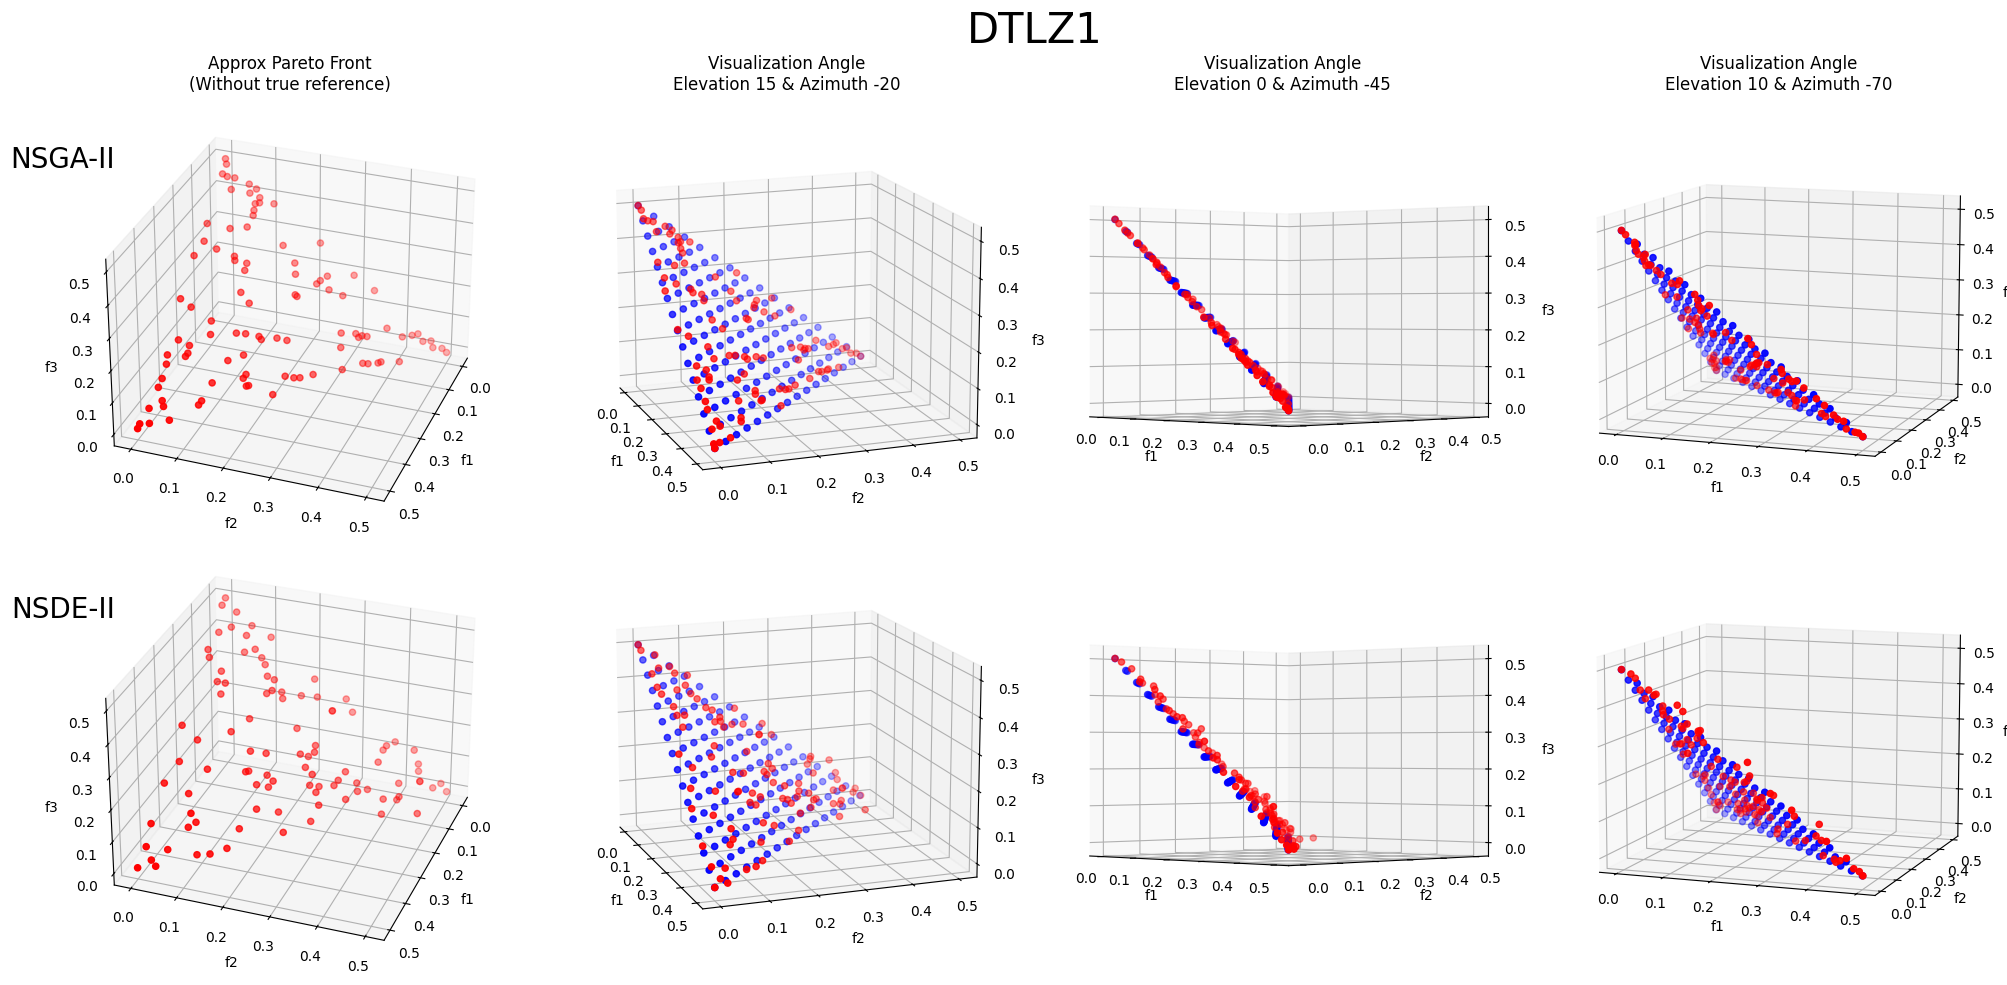

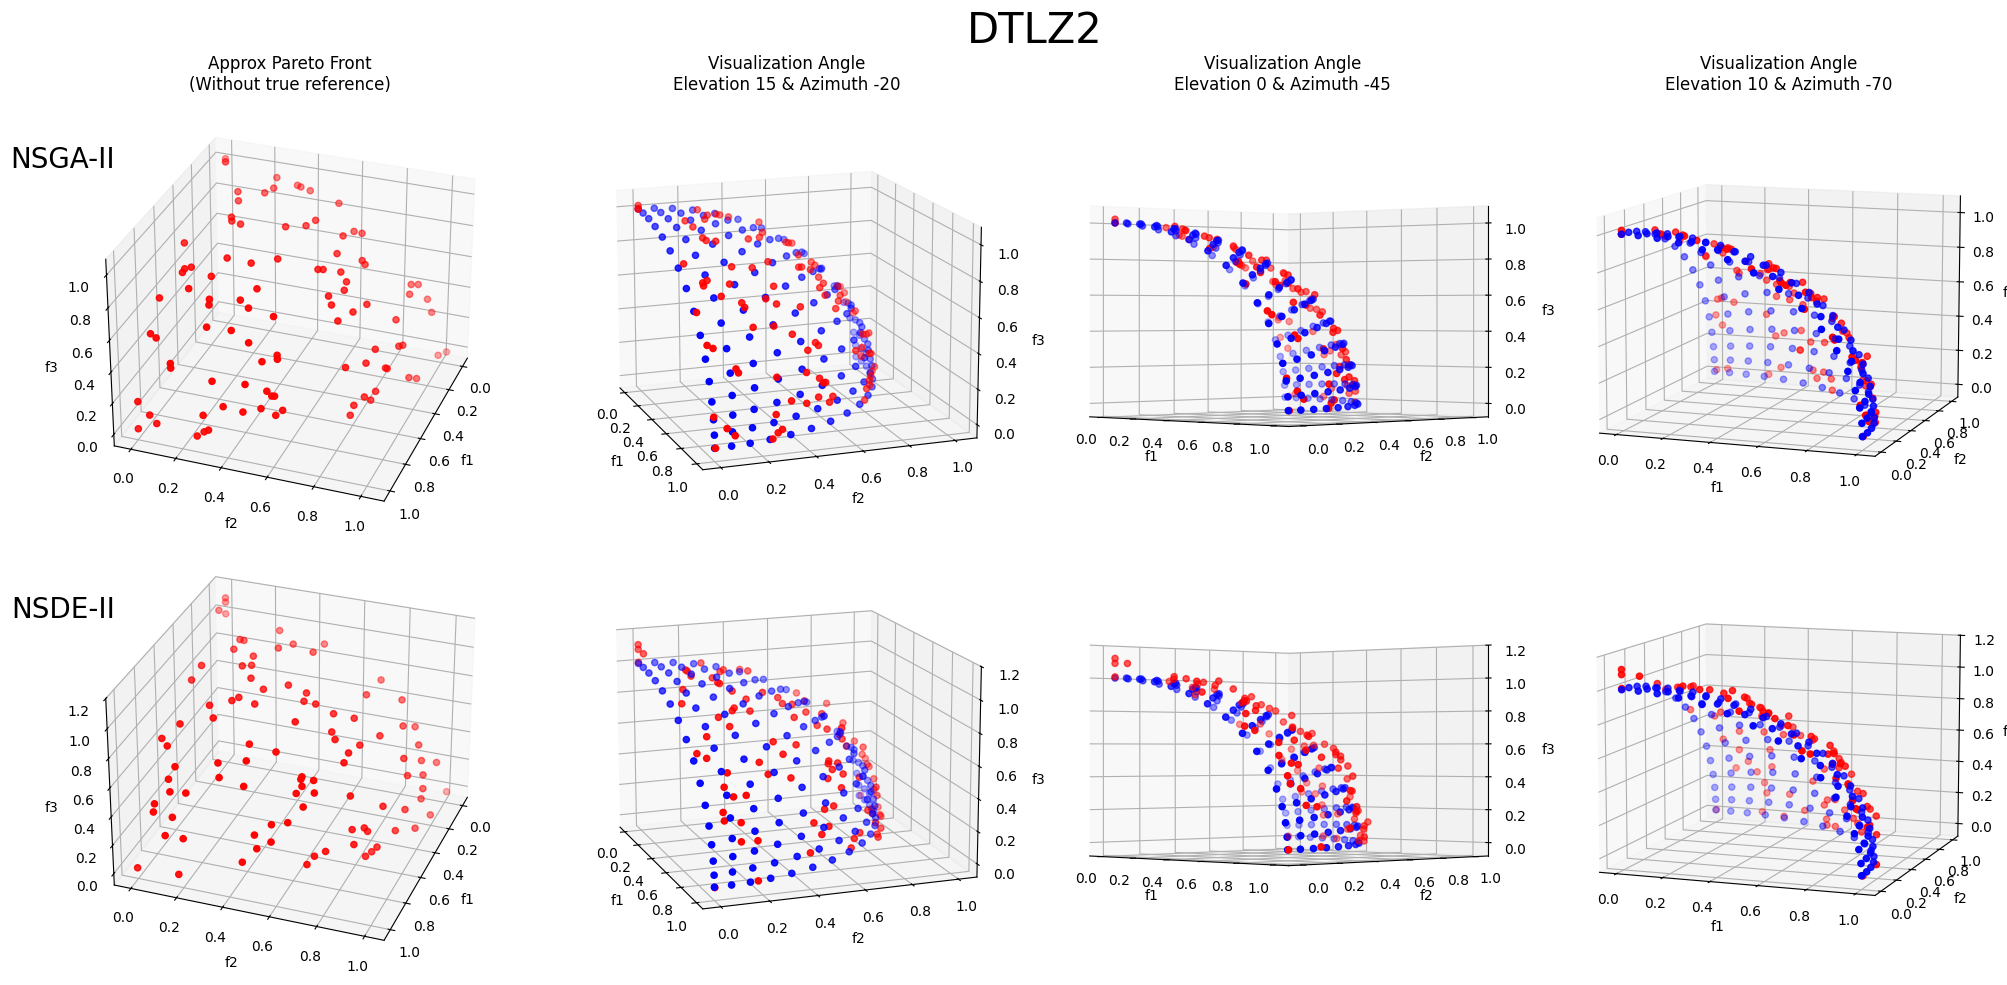

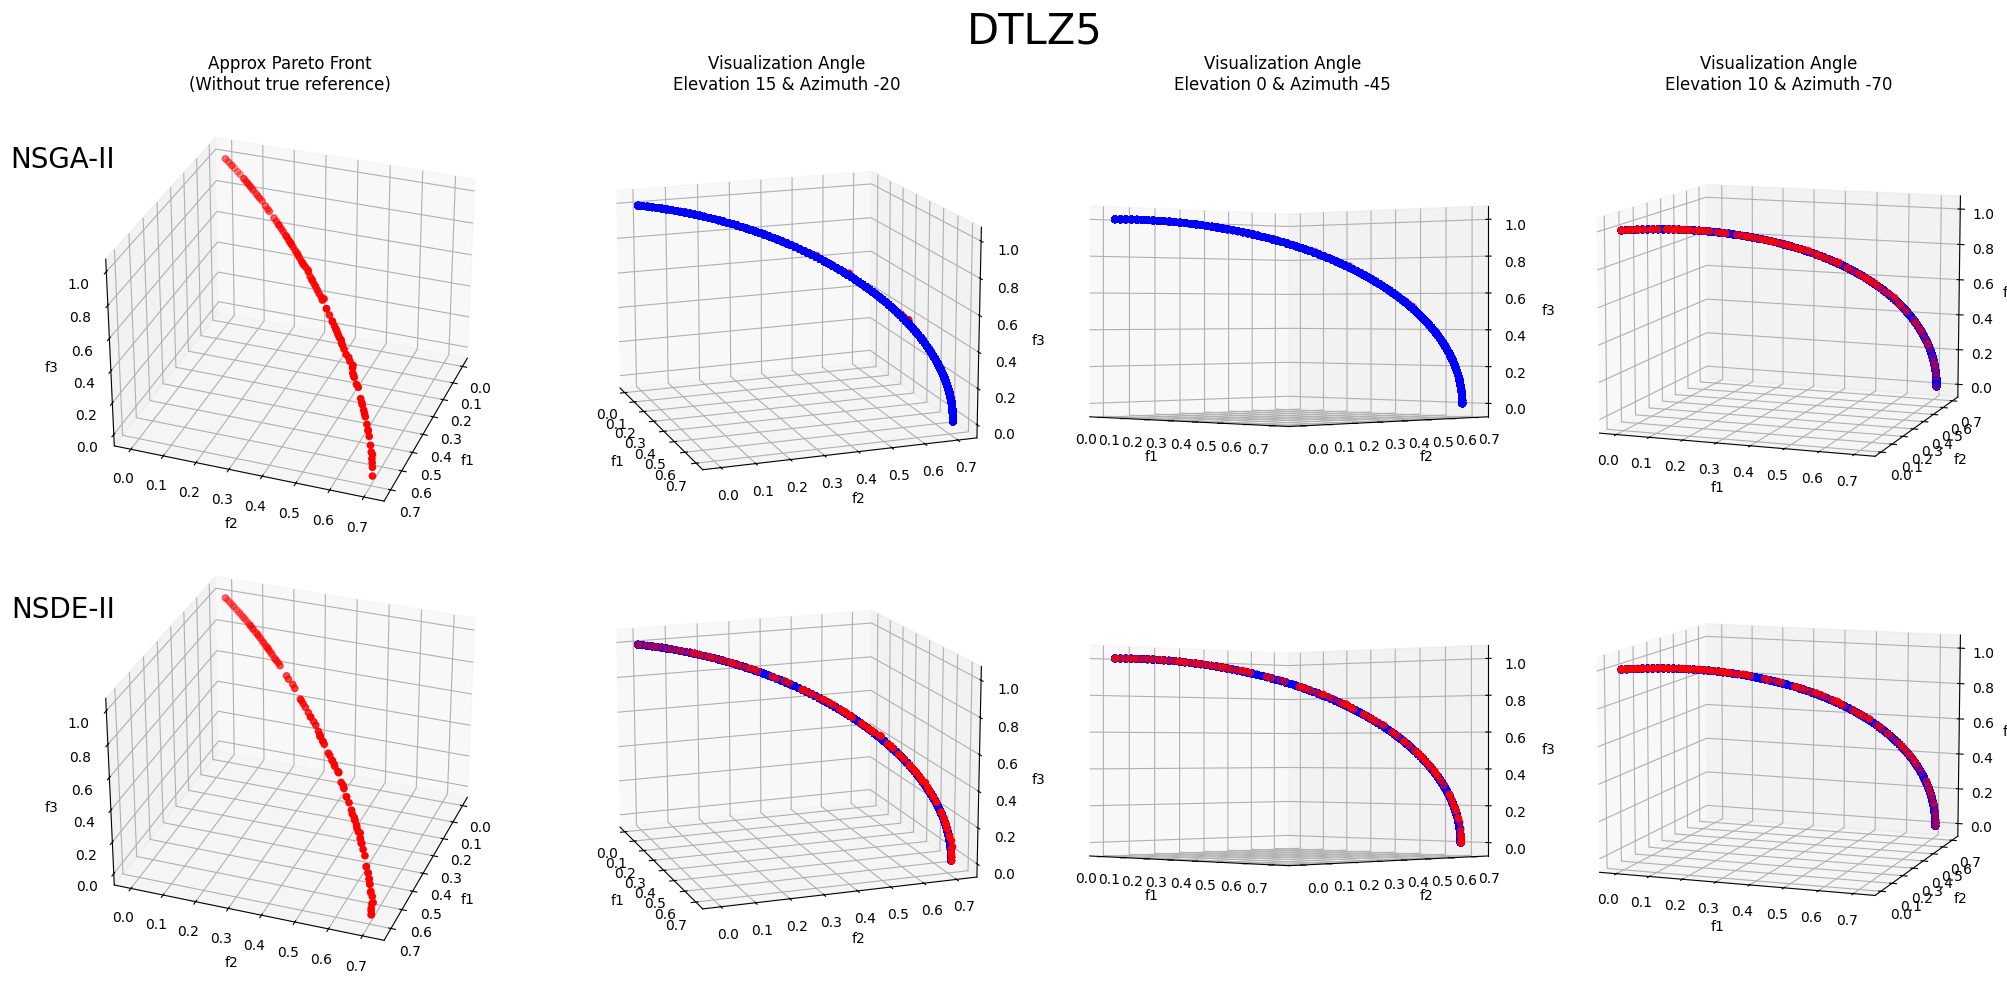

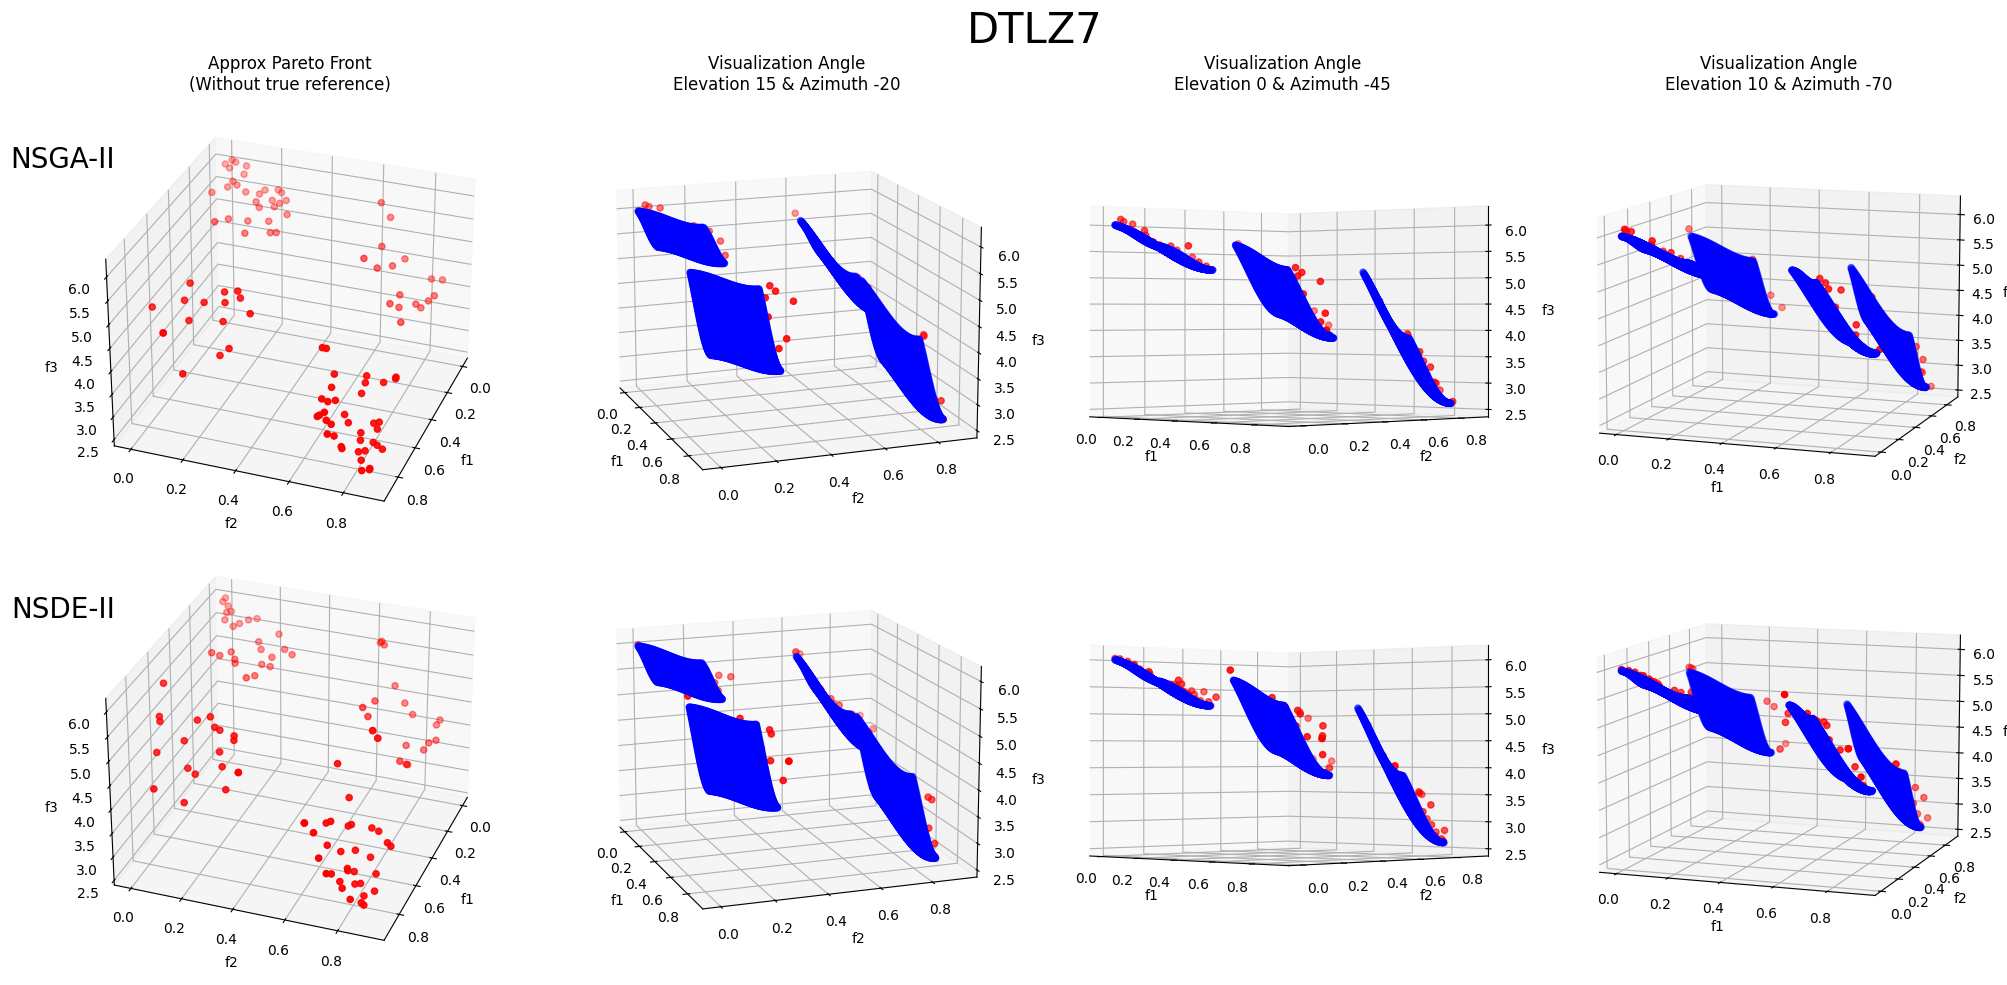

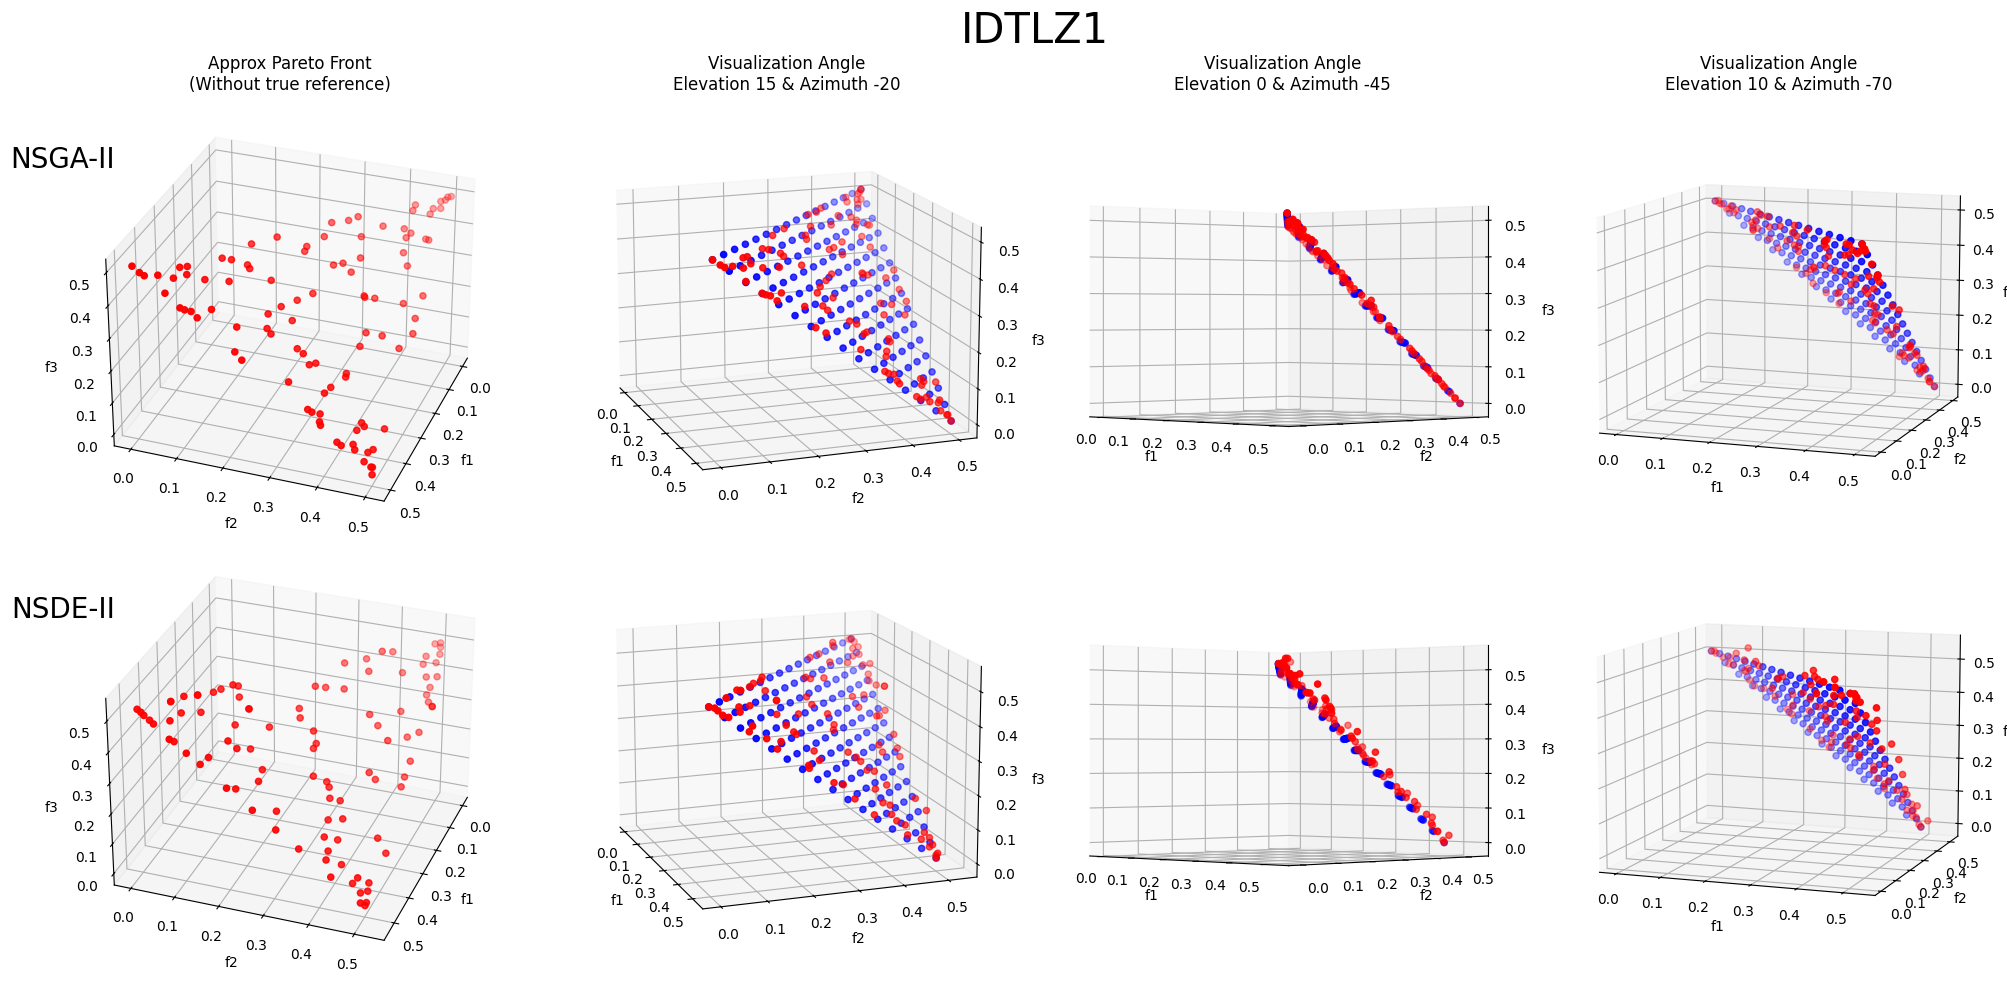

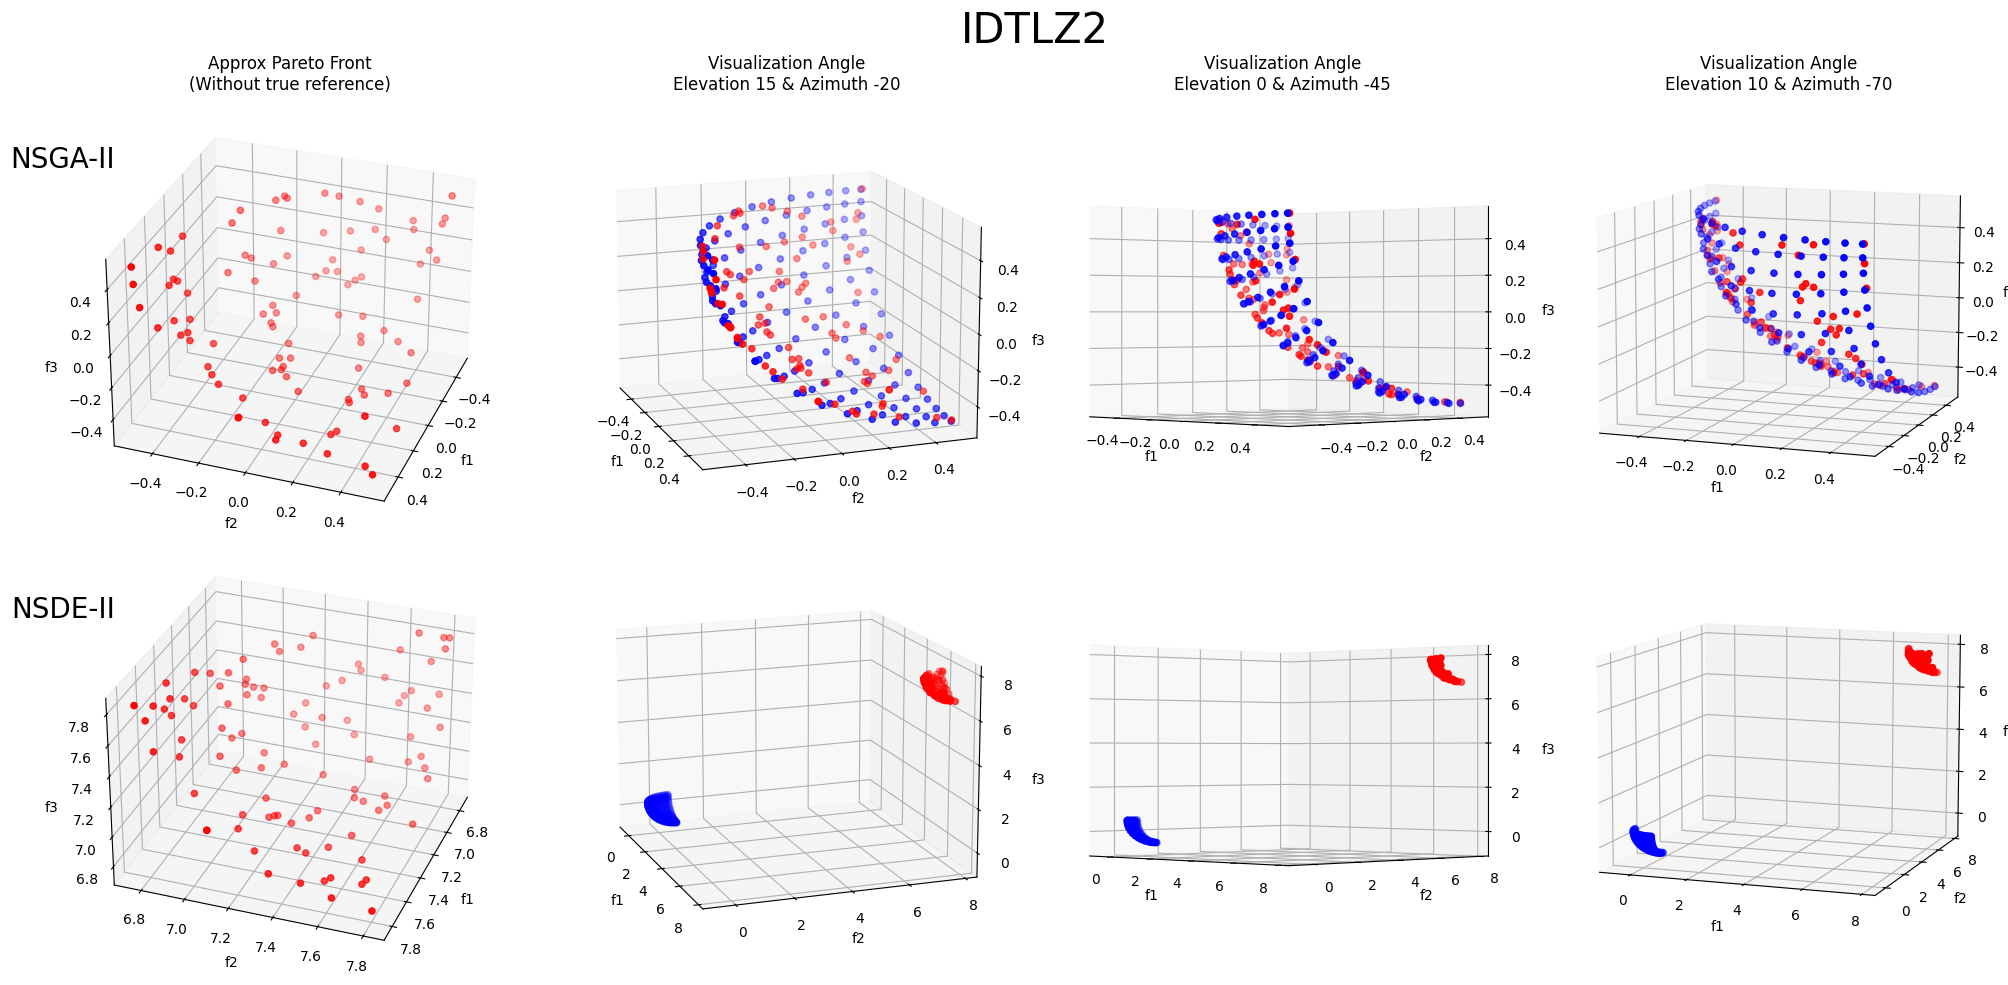

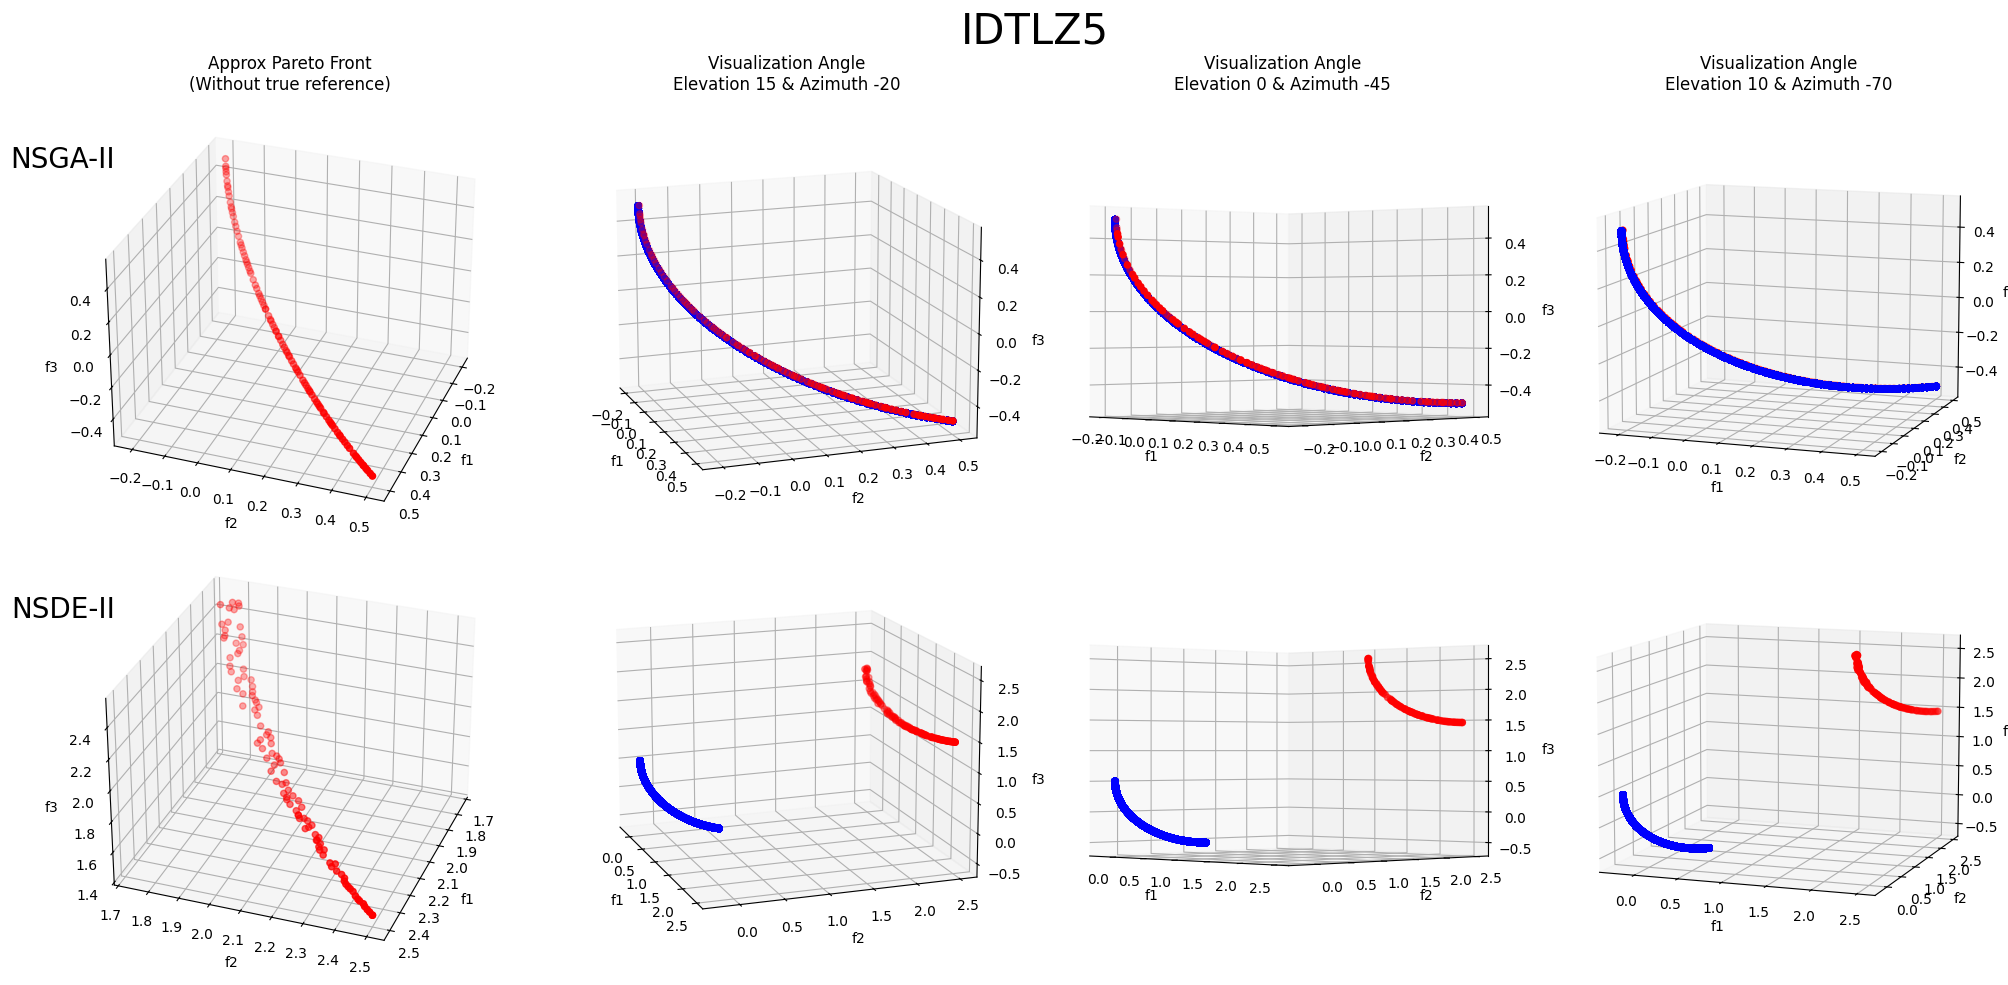

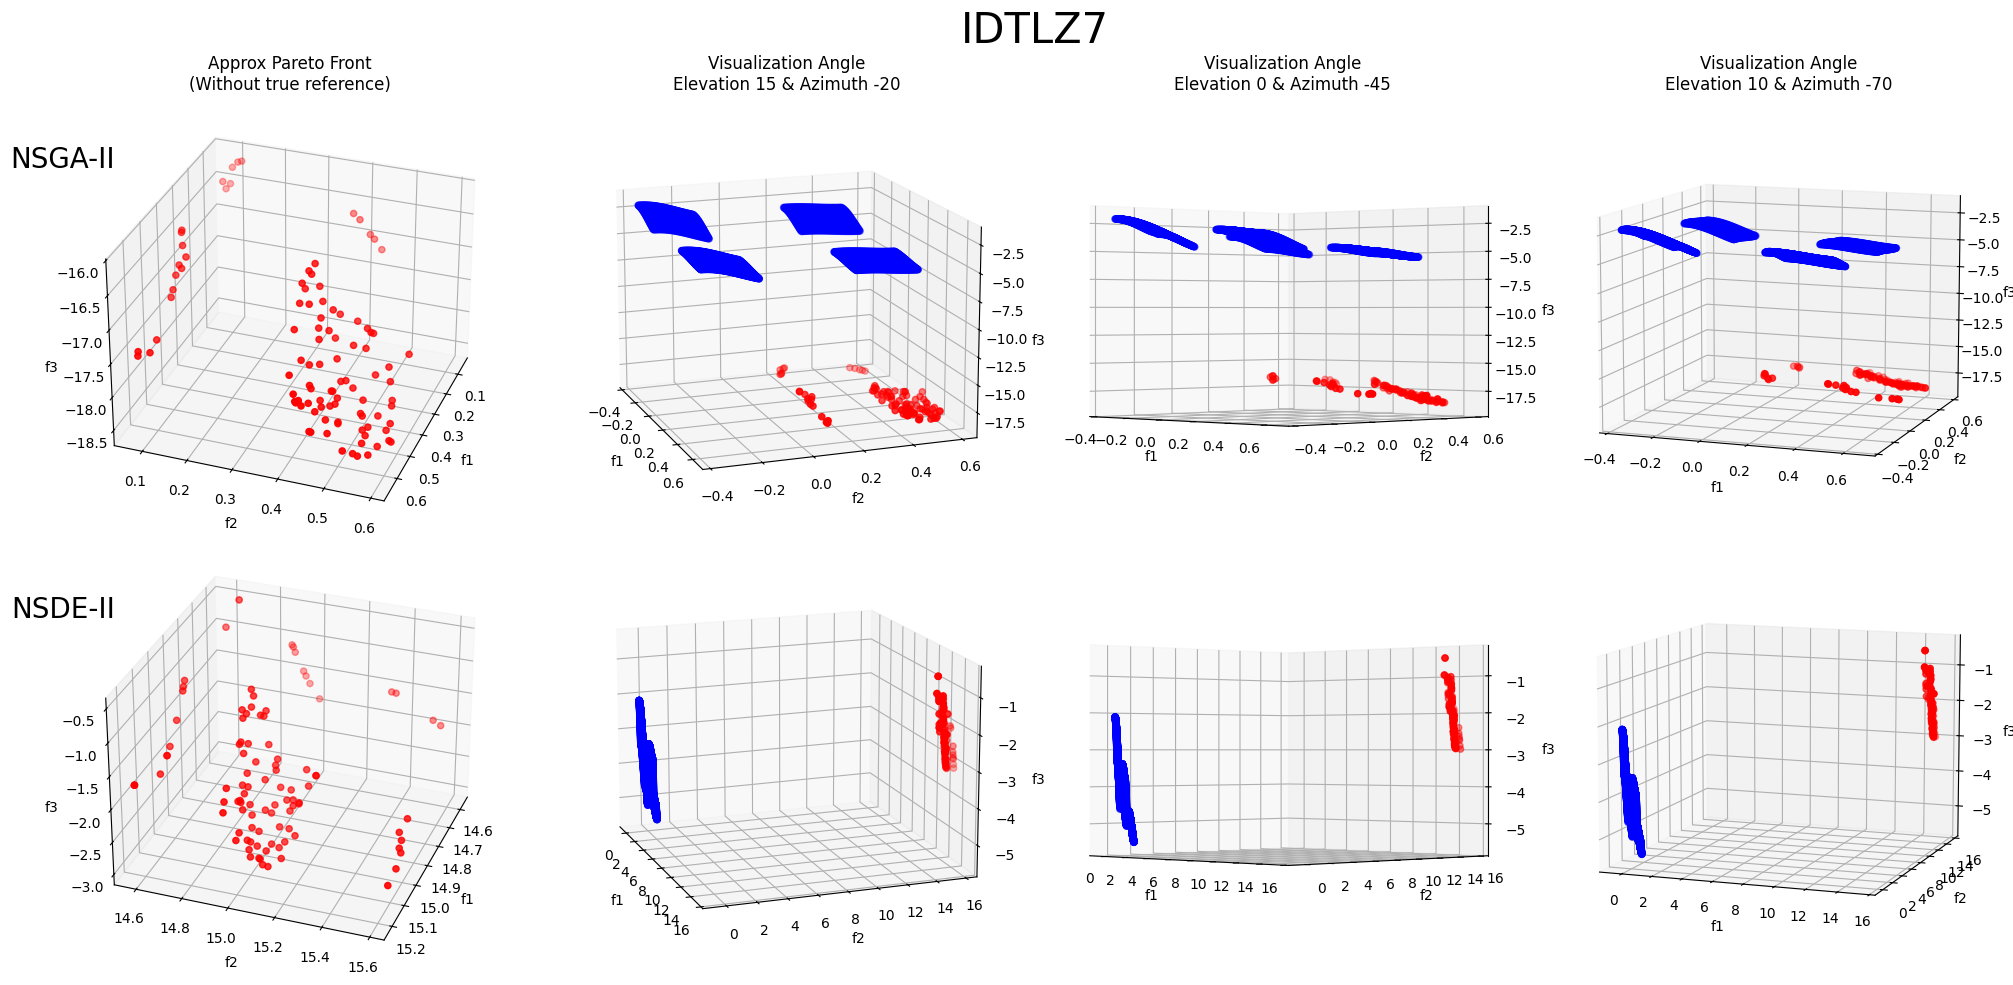

In [44]:

scatterPlots = []
for i, category in enumerate(PROBLEMS):
    for j, problem in enumerate(PROBLEMS[category]):
        fig, ax = plt.subplots(2, 4, figsize=(20, 10), subplot_kw={"projection" : "3d"})

        for k, results in enumerate([NSGAresults, NSDEresults]):

            # Get the Pareto front of the solution with the median R2
            solutions = list(zip(results[category][problem], [NSGAresults_R2, NSDEresults_R2][k][category][problem]))
            solutionsSorted = sorted(solutions, key=lambda x: x[1])

            paretoApprox = solutionsSorted[len(solutionsSorted) // 2][0].F

            # Get the real Pareto front
            paretoFront = PROBLEMS[category][problem].pareto_front() if category == "DTLZ" else 0.5 - PROBLEMS[category][problem].pareto_front()

            ax[0, 0].set_title(f"Approx Pareto Front\n(Without true reference)")
            ax[k, 0].scatter(paretoApprox[:, 0], paretoApprox[:, 1], paretoApprox[:, 2], color="red")
            ax[k, 0].set_xlabel("f1")
            ax[k, 0].set_ylabel("f2")
            ax[k, 0].set_zlabel("f3")
            ax[k, 0].view_init(elev=30, azim=20)

            for l, (elevation, angle) in enumerate([(15, -20), (0, -45), (10, -70)]):
                ax[0, l+1].set_title(f"Visualization Angle\nElevation {elevation} & Azimuth {angle}")
                ax[k, l+1].scatter(paretoFront[:, 0], paretoFront[:, 1], paretoFront[:, 2], color="blue")
                ax[k, l+1].scatter(paretoApprox[:, 0], paretoApprox[:, 1], paretoApprox[:, 2], color="red")
                ax[k, l+1].set_xlabel("f1")
                ax[k, l+1].set_ylabel("f2")
                ax[k, l+1].set_zlabel("f3")
                ax[k, l+1].view_init(elev=elevation, azim=angle)

        fig.text(0.04, 0.83, "NSGA-II", va="center", ha="right", fontsize=20)
        fig.text(0.04, 0.38, "NSDE-II", va="center", ha="right", fontsize=20)
        fig.suptitle(problem, fontsize=30)
        plt.tight_layout()
        plt.show()

## Conclusions

With multiobjective optimization having diverse real-life applications, it is imperative to develop robust models that can reach optimal or near-optimal solutions. With that in mind, in this study we assessed the performance of the common NSGA-II algorithm and a hybrid version denimonated NSDE-II using DE evolutionary operators, but the same survival mechanism of NSGA-II. These algorithms were tested against the same problems under the same number of generations (500) and the same number of individuals (100), with 30 independent executions per problem. We focused on comparing these algorithms with respect to two metrics: $R2$ and Riesz s-Energy, where the former measures the error of the solution (the closer to zero, the better the found solution) and where the latter measures the diversity of the distribution of points accross the Pareto front.

From our experiments, we can see how NSGA-II performs better than NSDE-II, this difference may not be noticed from the metrics, but it is clear when looking at the visualizations. NSGA-II converges towards the actual Pareto front in almost all problems (the exception being IDTLZ7), while NSDE-II fails to converge in the inverted problems. However, it is important to mention that although the results from NSDE-II do not reach the actual Pareto Front, the shape of the approximate Pareto Front holds the same shape as the actual one. Moreover, the algorithm keeps diversity in the solutions, which is even further validated when looking at the Wilcoxon test results, where none of the _p_ values of the Riesz s-Energy measure is statistically significant, meaning that our hybrid method and the baseline NSGA-II have essentially the same performance regarding the distribution of solutions across the Pareto front, even though from the table of the mean results it would appear that there was actually an improvement.

On the other hand, when looking at the $R2$ results, from the Wilcoxon test, we see that there is, indeed, a difference between the two algorithms. The only exception is the DTLZ5 problem, which based on the visualization, we can further confirm how the results from both algorithms are essentially the same. However, for the rest of the problems, we can also see on the Pareto front approximation visualizations, how NSDE-II does not converge into the actual Pareto front. In the non-inverted problems, the difference is marginal, with the approximate solution being really close to the ground truth. Nonetheless, on the inverted problems, we see how regardless of the shape being maintained, the approximate solution found by NSDE-II is relatively far from where the actual Pareto front is.

Therefore, when looking at this results, we can conclude that there is no particular benefit of resorting to the hybrid NSDE-II instead of the NSGA-II. Because there is no benefit in diversity, as they are statistically the same, and the performance is actually worse regarding the convergence into the actual Pareto front. However, it would be interesting to explore and tinker with other parameters such as the number of generations or the population size, because NSDE-II did keep the shape of the Pareto front in its approximations, so perhaps with different parameters, the solution could actually converge into the actual Pareto front.

## References

[1] Jesús Guillermo Falcón-Cardona, Lourdes Uribe, and Pablo Rosas. Riesz
s-Energy as a Diversity Indicator in Evolutionary Multi-Objective Optimization. IEEE Transactions on Evolutionary Computation, pages 1–15,
2024.

[2] Hisao Ishibuchi, Yu Setoguchi, Hiroyuki Masuda, and Yusuke Nojima. Performance of Decomposition-Based Many-Objective Algorithms Strongly Depends on Pareto Front Shapes. IEEE Transactions on Evolutionary Computation, 21(2):169–190, April 2017.

[3] C. A. Coello Coello, "Evolutionary multi-objective optimization: a historical view of the field," in IEEE Computational Intelligence Magazine, vol. 1, no. 1, pp. 28-36, Feb. 2006, doi: 10.1109/MCI.2006.1597059.

[4] K. Deb, A. Pratap, S. Agarwal and T. Meyarivan, "A fast and elitist multiobjective genetic algorithm: NSGA-II," in IEEE Transactions on Evolutionary Computation, vol. 6, no. 2, pp. 182-197, April 2002, doi: 10.1109/4235.996017.

[5] Deb, K., Thiele, L., Laumanns, M., Zitzler, E. (2005). Scalable Test Problems for Evolutionary Multiobjective Optimization. In: Abraham, A., Jain, L., Goldberg, R. (eds) Evolutionary Multiobjective Optimization. Advanced Information and Knowledge Processing. Springer, London. https://doi.org/10.1007/1-84628-137-7_6

[6] Dimo Brockhoff, Tobias Wagner, and Heike Trautmann. On the Properties of the R2 Indicator. In 2012 Genetic and Evolutionary Computation
Conference (GECCO’2012), pages 465–472, Philadelphia, USA, July 2012.
ACM Press. ISBN: 978-1-4503-1177-9.